In [364]:
import os
# import pysam
# import pybedtools
import argparse
import tables
import numpy as np
import math
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
%matplotlib inline

In [365]:
window = None
step = None

In [366]:
def parse_h5_files(text):
    global window
    global step
    textfile = open(text)
    path = textfile.readline().split('\n')[0]
    files = []

    while path != "":
        # todo
        file = tables.open_file(path)
        w = file.get_node(where=file.root.stats, name='window')[...][()]
        s = file.get_node(where=file.root.stats, name='step')[...][()]
        if window is None or step is None:
            window = w
            step = s
        if w != window or s != step:
            raise Exception("Window and step sizes must be same among all HDF5 files")
        files.append(file)
        path = textfile.readline().split('\n')[0]

    return files

In [367]:
def get_chr_subarray_exclusive(file, chr, start, end):
    """START and END are exclusive, i.e. only copynum for
    windows that are within START and END are returned"""
    start_window = math.ceil(np.divide(start, step)) # todo: is this right?
    end_window = math.ceil(np.divide(end - window, step)) # todo: is this right?
    chrom_group = file.get_node(where=file.root.depth, name=chr)
    start_idx = file.get_node(where=file.root.depth, name=chr).start[start_window]
    end_idx = file.get_node(where=file.root.depth, name=chr).end[end_window - 1]
    return start_idx, end_idx, chrom_group.copy_number[start_window:end_window] # end index of splice is exclusive

def get_chr_subarray_inclusive(file, chr, start, end):
    """START and END are inclusive, i.e. the smallest range
    of windows that include START and END are returned"""
    start_window = start // step # todo: is this right?
    end_window = math.ceil(np.divide(end - window, step)) + 1 # todo: is this right?
    chrom_group = file.get_node(where=file.root.depth, name=chr)
    start_idx = file.get_node(where=file.root.depth, name=chr).start[start_window]
    end_idx = file.get_node(where=file.root.depth, name=chr).end[end_window - 1]
    return start_idx, end_idx, chrom_group.copy_number[start_window:end_window] # end index of splice is exclusive

get_chr_subarray = get_chr_subarray_inclusive

In [368]:
def close_files(files):
    for f in files:
        f.close()

def subarray_func(exclusive):
    global get_chr_subarray
    if exclusive:
        get_chr_subarray = get_chr_subarray_exclusive

In [369]:
txt_files = {"verus": "verus.txt", "ellioti": "ellioti.txt", "troglodytes": "troglodytes.txt", "schweinfurthii": "schweinfurthii.txt", "bonobos": "bonobos.txt"}
h5_files = {}

for file in txt_files:
    h5_files[file] = parse_h5_files(txt_files[file])

In [370]:
def make_histogram(name, chrom, start, end, bins, color):
    cn_arrays = {}

    for lst in h5_files:
        copy_nums = []
        start_idx, end_idx = None, None
        for f in h5_files[lst]:
            if start_idx is None or end_idx is None:
                start_idx, end_idx, cn_arr = get_chr_subarray(f, chrom, start, end)
            else:
                s, e, cn_arr = get_chr_subarray(f, chrom, start, end)
                if s != start_idx or e != end_idx:
                    print("Start and end chromosome indices are not equal")
            copy_nums.append(np.average(cn_arr))

        cn_arrays[lst] = copy_nums
        
    bins = np.linspace(0, 3, 20) # NOTE: THIS OVERRIDES THE bins ARGUMENT
   
    assert(len(color) == len(cn_arrays))
    plt.figure(figsize=(12, 6))
    n, bins, patches = plt.hist(list(cn_arrays.values()), bins=bins, color=color, label=cn_arrays.keys(), stacked=True)
    plt.legend(loc=(1.05, 0.7))
    plt.yticks(np.arange(np.max(n) + 1))
    
    if name is None:
        plt.title("{chrom}:{start}-{end}".format(chrom=chrom, start=start_idx, end=end_idx))
    else:
        plt.title("{name} {chrom}:{start}-{end}".format(name=name, chrom=chrom, start=start_idx, end=end_idx))
    plt.xlabel("Copy number")
    plt.ylabel("Number of individuals")


In [371]:
colors = ['red', 'green', 'blue', 'orange', 'gray']
chimps = ['verus', 'ellioti', 'troglodytes', 'schweinfurthii', 'bonobos']

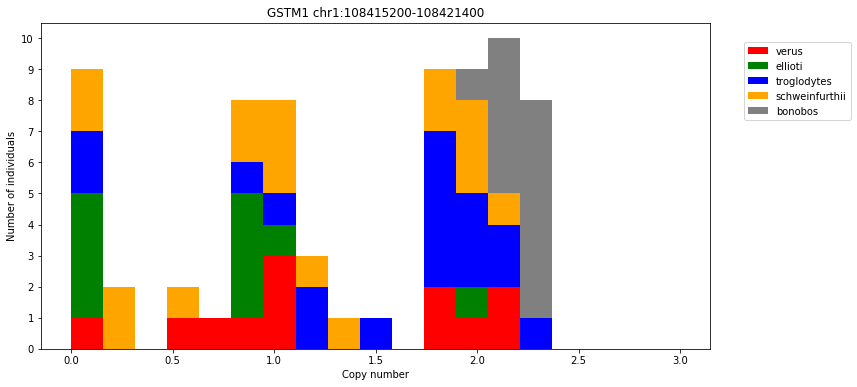

In [372]:
make_histogram("GSTM1", "chr1", 108415386, 108421358, 20, colors)

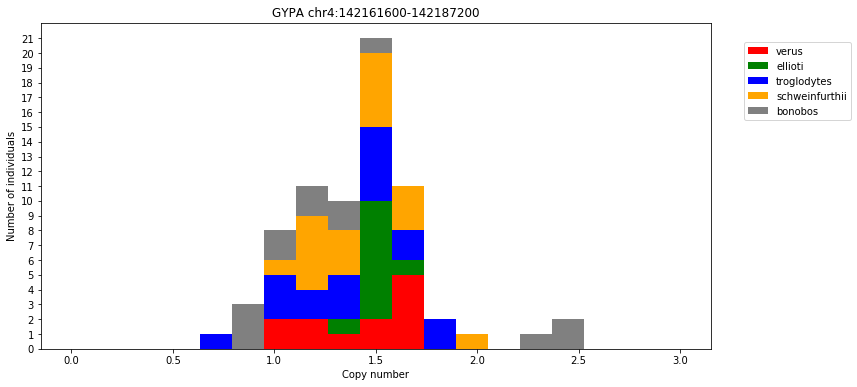

In [374]:
# chr4    142161703   142187051   GYPA
make_histogram("GYPA", "chr4", 142161703, 142187051, 20, colors)

In [375]:
def make_histogram_2(h5_files, name, chrom, start, end, bins, color, label):
    
    copy_nums = []
    start_idx, end_idx = None, None
    for f in h5_files:
        if start_idx is None or end_idx is None:
            start_idx, end_idx, cn_arr = get_chr_subarray(f, chrom, start, end)
        else:
            s, e, cn_arr = get_chr_subarray(f, chrom, start, end)
            if s != start_idx or e != end_idx:
                print("Start and end chromosome indices are not equal")

        copy_nums.append(np.average(cn_arr))

    bins = np.linspace(0, 3, 20) # NOTE: THIS OVERRIDES THE bins ARGUMENT
    n, unused1, unused2 = plt.hist(copy_nums, bins, color=color, label=label)
    plt.legend(loc="upper right")
    plt.yticks(np.arange(np.max(n) + 2))

    if name is None:
        plt.title("{chrom}:{start}-{end}".format(chrom=chrom, start=start_idx, end=end_idx))
    else:
        plt.title("{name} {chrom}:{start}-{end}".format(name=name, chrom=chrom, start=start_idx, end=end_idx))
    plt.xlabel("Copy number")
    plt.ylabel("Number of individuals")

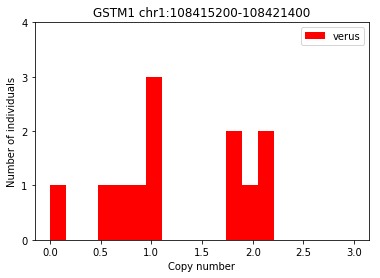

In [376]:
make_histogram_2(h5_files['verus'], "GSTM1", "chr1", 108415386, 108421358, 20, 'red', 'verus')

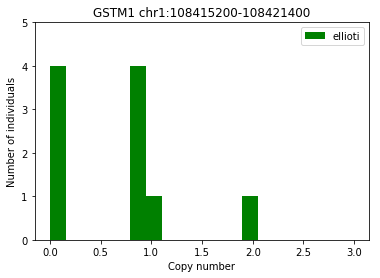

In [377]:
make_histogram_2(h5_files['ellioti'], "GSTM1", "chr1", 108415386, 108421358, 20, 'green', 'ellioti')

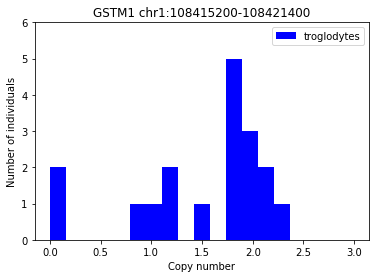

In [378]:
make_histogram_2(h5_files['troglodytes'], "GSTM1", "chr1", 108415386, 108421358, 20, 'blue', 'troglodytes')

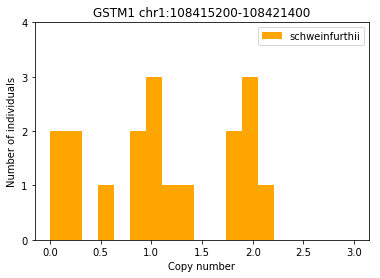

In [379]:
make_histogram_2(h5_files['schweinfurthii'], "GSTM1", "chr1", 108415386, 108421358, 20, 'orange', 'schweinfurthii')

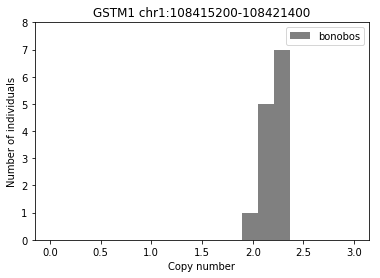

In [380]:
make_histogram_2(h5_files['bonobos'], "GSTM1", "chr1", 108415386, 108421358, 20, 'gray', 'bonobos')

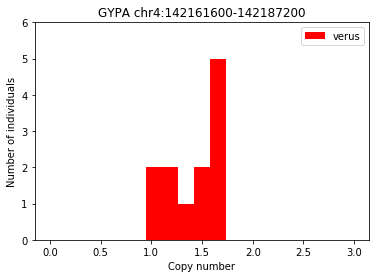

In [381]:
i = 0
make_histogram_2(h5_files[chimps[i]], "GYPA", "chr4", 142161703, 142187051, 20, colors[i], chimps[i])

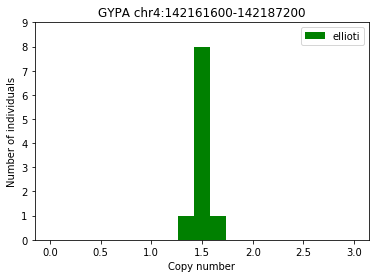

In [382]:
i = 1
make_histogram_2(h5_files[chimps[i]], "GYPA", "chr4", 142161703, 142187051, 20, colors[i], chimps[i])

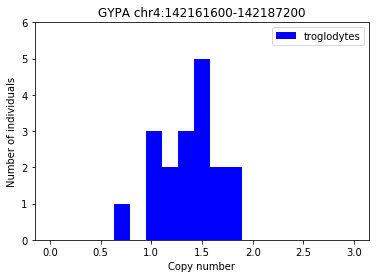

In [383]:
i = 2
make_histogram_2(h5_files[chimps[i]], "GYPA", "chr4", 142161703, 142187051, 20, colors[i], chimps[i])

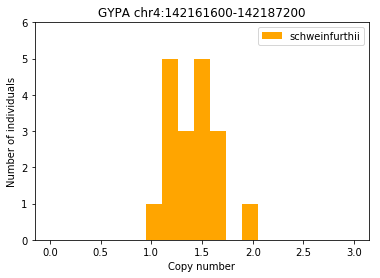

In [384]:
i = 3
make_histogram_2(h5_files[chimps[i]], "GYPA", "chr4", 142161703, 142187051, 20, colors[i], chimps[i])

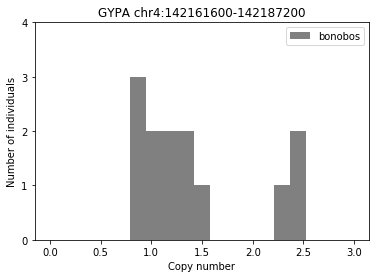

In [385]:
i = 4
make_histogram_2(h5_files[chimps[i]], "GYPA", "chr4", 142161703, 142187051, 20, colors[i], chimps[i])

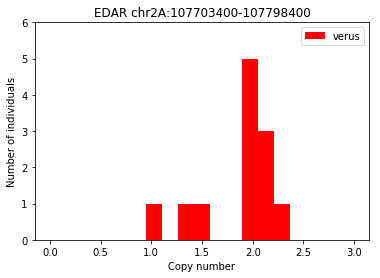

In [386]:
i = 0
make_histogram_2(h5_files[chimps[i]], "EDAR", "chr2A", 107703547, 107798380, 20, colors[i], chimps[i])

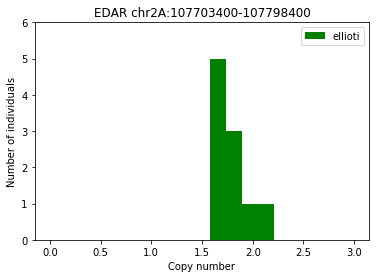

In [387]:
i = 1
make_histogram_2(h5_files[chimps[i]], "EDAR", "chr2A", 107703547, 107798380, 20, colors[i], chimps[i])

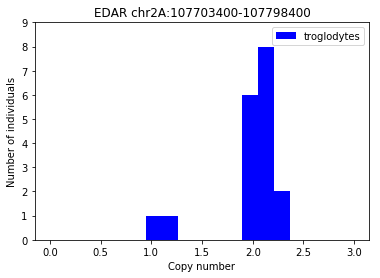

In [388]:
i = 2
make_histogram_2(h5_files[chimps[i]], "EDAR", "chr2A", 107703547, 107798380, 20, colors[i], chimps[i])

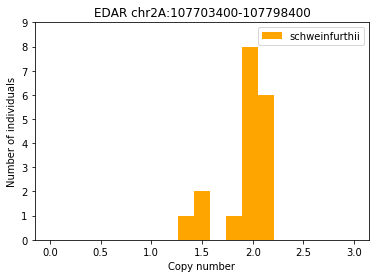

In [389]:
i = 3
make_histogram_2(h5_files[chimps[i]], "EDAR", "chr2A", 107703547, 107798380, 20, colors[i], chimps[i])

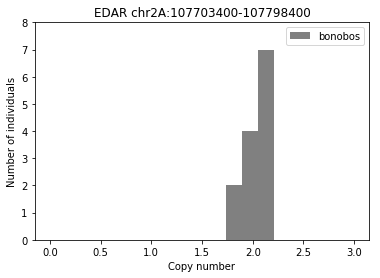

In [390]:
i = 4
make_histogram_2(h5_files[chimps[i]], "EDAR", "chr2A", 107703547, 107798380, 20, colors[i], chimps[i])

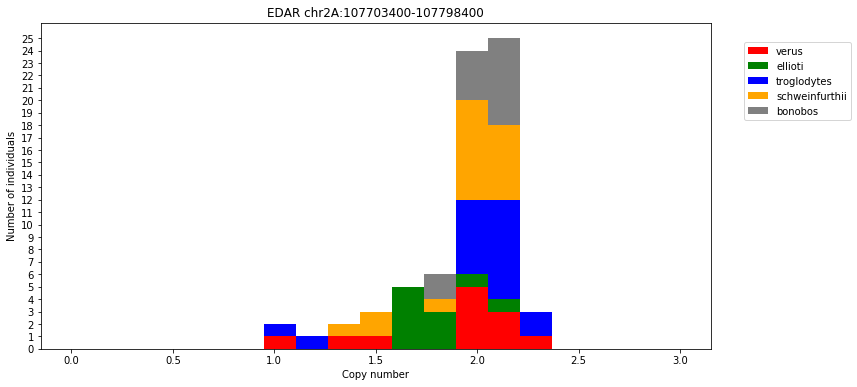

In [391]:
make_histogram("EDAR", "chr2A", 107703547, 107798380, 20, colors)

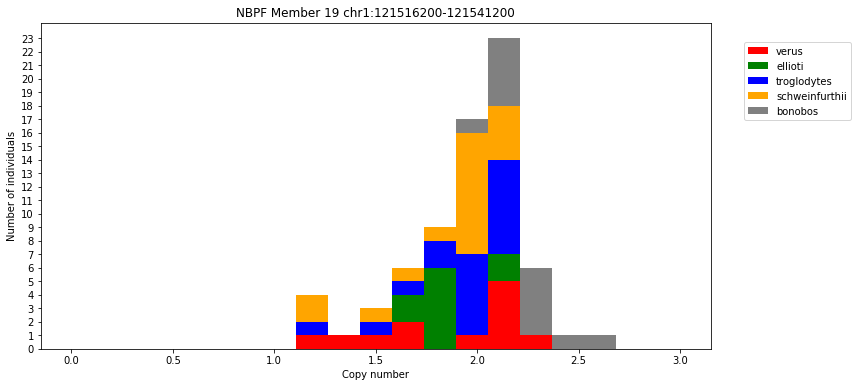

In [392]:
make_histogram("NBPF Member 19", "chr1", 121516304, 121541084, 20, colors)

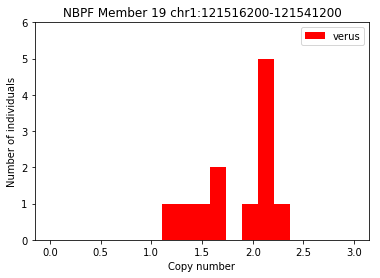

In [393]:
i = 0
make_histogram_2(h5_files[chimps[i]], "NBPF Member 19", "chr1", 121516304, 121541084, 20, colors[i], chimps[i])

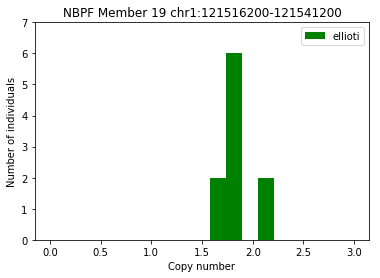

In [394]:
i = 1
make_histogram_2(h5_files[chimps[i]], "NBPF Member 19", "chr1", 121516304, 121541084, 20, colors[i], chimps[i])

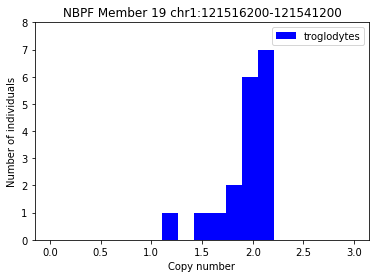

In [395]:
i = 2
make_histogram_2(h5_files[chimps[i]], "NBPF Member 19", "chr1", 121516304, 121541084, 20, colors[i], chimps[i])

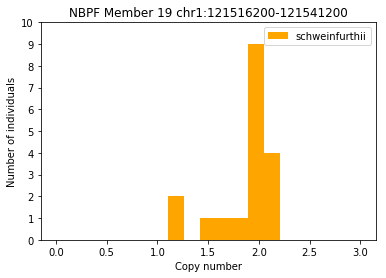

In [396]:
i = 3
make_histogram_2(h5_files[chimps[i]], "NBPF Member 19", "chr1", 121516304, 121541084, 20, colors[i], chimps[i])

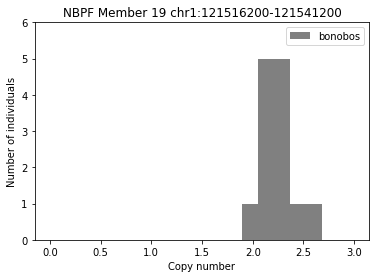

In [397]:
i = 4
make_histogram_2(h5_files[chimps[i]], "NBPF Member 19", "chr1", 121516304, 121541084, 20, colors[i], chimps[i])